## Trying to convert HDDM model object to ArviZ

Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com

I tried to convert `HDDM` model object to `Arviz`'s `InferenceData` so that we can use the statistical functions of `Arviz`, such as `loo`, `waic`, and `plot_ppc`.

Data used in this script: the example data from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html). 

Computing environment: a [HDDM docker image](https://hub.docker.com/r/hcp4715/hddm), tag: `hcp4715/hddm:arviz`.
 
Previously, I had an issue: `nan` was genrated when converting a Dataframe of point-wise likelihood to Xarray, see [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268). 

After looking into the `loglikelihood` generated from `pymc3` (through `bambi`), I found that the point-wise log likelihood has only three dimensions: chain, draw, and observations, which avoid the problem of unequal numbers of observations across conditions/subjects.

Also importantly, for hierarchical models, there are different ways for `loo`: leave-one-observation-out, or leave-one-group-out (or leave-one-subject-out in this case), see [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268) and [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268) for more details.

In this script, I included two approaches for `loo`: leave one observation out and leave one subject-condition pair out.

As in the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html), I built two models, M0 uses `hddm.HDDM` without any further `depends_on` argument, M1 with a `depends_on` argument. Then I used `loo` and `waic` to compare the two models.


**PS:**
There are some zeros when calculating pointwise likelihood, which will cause `nan` when converted to `log` likelihood. To avoid this problem, I replaced zero with mean value of that particular condition. (I also tried to replace zeros with $\frac {1}{1e300}$, which makes the loglikelihood extremely large).

**PPS:**
The scripts here may only work for the  models I specified based on `cavanagh_theta_nn.csv`. I do not guarantee that the code is correct.

**Questions:**
* How to deal with 0 likelihoods?
* How to calculate group loglikelihood when observations in each group are different? using sum or mean?
* A technique issue: How to stop the progress bar of `hddm` print on new line??

In [1]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import sparse # test whether package `sparse` is installed; doesn't matter if not installed.

from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0


### Description of the issue

In the data, there are 14 participants (0 ~  13), and three conditions: LL, WL, and WW. The number of trials of each each condition of each participant are not equal. 

When calculating the point-wise likielihood, I calculated the `pdf` of each trial's data, conditioned on the sample from posterior of all parameters. 

There are two sources of `nan`.

1. when the likelihood is $0$, the $log(0)$ is `nan`. This can be solved by replacing $0$ with other number, I used mean value of that whole array.

2. Unequal number of trials across conditions. When converting the dataframe of $elppd$ to `Xarray` datasets, **with `subj_idx`, `stim`, `trial`, `draw`, and `chain` as dimensions**, `Xarray` force the length of `trial` to be the maximum number of trials and filled `nan` to those with smaller number of trials. This can be solved by only using `chain`, `draw`, and `range(len(observations)` as dimensions.

## Loading data

The data is from `HDDM` package itself, but it was hidden somewhere:

In [2]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)
# !head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

In [3]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
# data.head()

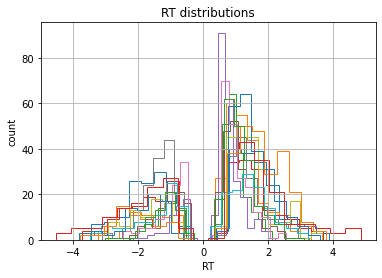

In [4]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

In [5]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model and convert

### Model specification
Here we used a model from the official tutorial:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

We used parallel processing by `p_tqdm`.

We will only use 1500 sample and burnin 500.

In [6]:
# define a function to run model in parallel
def run_m0(id, df=None, samples=None, burn=None, save_name=None): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

def run_m1(id, df=None, samples=None, burn=None, save_name=None): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [7]:
# define a func for calculating the point-wise log likelihood
# we can then use parallel processing for it
def calc_plld(m, observed=None, *argm):
    """
    m: HDDM model object, not a list
    observed: observed data from which the model was built
    """
    # data_grouped = observed.groupby(['subj_idx', 'stim'])
    tmp_posterior = m.get_traces()
    df_loglik = []

    ### temporary solution: if no "(" in column, indicate a simple model
    if len([col for col in tmp_posterior.columns if "(" in col]) == 0:
        data_grouped = observed.groupby(['subj_idx'])

        for group_name, df_grouped in data_grouped:
            #print("sub: ", group_name[0])
            #print("stim: ", group_name[1])
            tmp_df =data_grouped.get_group(group_name)
            tmp_df = np.array(tmp_df['rt'])

            a_colname = "a_subj." + str(group_name)
            t_colname = "t_subj." + str(group_name)
            v_colname = "v_subj." + str(group_name)

            for index, row in tmp_posterior.iterrows():
                tmp_a = row[a_colname]
                tmp_t = row[t_colname]
                tmp_v = row[v_colname]

                # Here we start using the pdf func of wfpt to calculate the likelihood
                tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)

                if np.sum(tmp_lik == 0.0) > 0:
                    # print('Likelihood is zero, converted to 1/1e3 !\n')
                    tmp_lik[tmp_lik == 0.0] = 1/1e300

                elif np.sum(np.isnan(tmp_lik))  > 0:
                    print('NAN in the likelihood, check the data !')
                    break

                obs = np.log(tmp_lik)

                if np.sum(np.isinf(obs)) > 0:
                    print('Correction does not work!!!\n')

                tmp_df_pll = pd.DataFrame({'obs': obs,
                                           'draw': index,
                                           'subj_idx': group_name})
                tmp_df_pll['trial'] = tmp_df_pll.groupby(['draw', 'subj_idx']).cumcount()
                df_loglik.append(tmp_df_pll)

    else:
        data_grouped = observed.groupby(['subj_idx', 'stim'])

        for group_name, df_grouped in data_grouped:
            #print("sub: ", group_name[0])
            #print("stim: ", group_name[1])
            tmp_df =data_grouped.get_group(group_name)
            tmp_df = np.array(tmp_df['rt'])

            a_colname = "a_subj." + str(group_name[0])
            t_colname = "t_subj." + str(group_name[0])
            v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

            for index, row in tmp_posterior.iterrows():
                tmp_a = row[a_colname]
                tmp_t = row[t_colname]
                tmp_v = row[v_colname]

                # Here we start using the pdf func of wfpt to calculate the likelihood
                tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)

                if np.sum(tmp_lik == 0.0) > 0:
                    # print('Likelihood is zero, converted to 1/1e3 !\n')
#                     tmp_lik[tmp_lik == 0.0] = 1/1e300
                    tmp_lik[tmp_lik == 0.0] = np.mean(tmp_lik)

                elif np.sum(np.isnan(tmp_lik))  > 0:
                    print('NAN in the likelihood, check the data !')
                    break

                obs = np.log(tmp_lik)

                if np.sum(np.isinf(obs)) > 0:
                    print('Correction does not work!!!\n')

                tmp_df_pll = pd.DataFrame({'obs': obs,
                                           'draw': index,
                                           'subj_idx': group_name[0],
                                           'stim': group_name[1]})
                tmp_df_pll['trial'] = tmp_df_pll.groupby(['draw', 'subj_idx', 'stim']).cumcount()
                df_loglik.append(tmp_df_pll)
        
    df_loglik = pd.concat(df_loglik)
            
    return df_loglik

Here we define a function to run the model, get posterior, generate posterior predictive, and calculate the point-wise log likelihood. The steps inside can be executed separately too.

In [8]:
# we can put all the above in a function to run all the coverting
# note: this function is specified for  this model
def model_fitting(df, run_model = None, chains=4, samples=500, burn=200, model_name='m_db', **kwargs):
    """
    from data to arviz data
    """
    import arviz as az
    import numpy as np
    import pandas as pd
    import xarray as xr
    
    import hddm
    import kabuki
    
    from p_tqdm import p_map
    from functools import partial
    
    # NOTE: I hacked the `post_pred_gen`, 
    # more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
    from post_pred_gen_redifined import _parents_to_random_posterior_sample
    from post_pred_gen_redifined import _post_pred_generate
    from post_pred_gen_redifined import post_pred_gen

    
    # step 1: run model, list    
    ms = p_map(partial(run_model, df=df, samples=samples, 
                       burn=burn, save_name=model_name),
               range(chains))
    
    # step 2: Get posterior trace
    df_traces = []
    for jj in range(len(ms)):
        m = ms[jj]
        trace_tmp = m.get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
#         print('chain', jj, trace_tmp.shape)
        df_traces.append(trace_tmp)
    df_traces = pd.concat(df_traces)
    
    # step 3: get ppc, return df_ppc, a dataframe
    # this part is specific to the current model, need to be change for more 
    # general purpose
    ppc_list = p_map(partial(post_pred_gen, 
                             samples = samples - burn),
                     ms)
    df_ppc = []
    for kk in range(len(ppc_list)):
        ppc_tmp = ppc_list[kk].copy()
        ppc_tmp.reset_index(inplace=True)
        ppc_tmp['chain'] = kk
        ppc_tmp.rename(columns={'sample':'draw',
                                'level_2':'trial'}, inplace=True)
#         print('\nchain', kk, ppc_tmp.shape)
        ppc_tmp[['node_', 'subj_idx']] = ppc_tmp['node'].str.split(pat='\.', expand=True)

        # check it the "node_" contain "()"
        # if yes, extract the substring between "(" and ")"
        if ppc_tmp['node_'].str.contains("\(").any(): 
            ppc_tmp['stim'] = ppc_tmp['node_'].str.extract('.*\((.*)\).*')
            ppc_tmp.drop('node', axis=1, inplace=True)
        else:
            ppc_tmp.drop('node_', axis=1, inplace=True)
        df_ppc.append(ppc_tmp)
    df_ppc = pd.concat(df_ppc)
    
    # step 3: get point-wise likelihoods, list
    loglik_list = p_map(partial(calc_plld, observed=df), ms)
    
    for chain in range(len(loglik_list)):
        loglik_list[chain]['chain'] = chain   
    df_loglik = pd.concat(loglik_list)

    return ms, df_traces, df_ppc, df_loglik

In [9]:
def to_infdata(df=None, df_traces=None, df_ppc=None, df_loglik=None, level="obs"):
#     obs_data_tmp = df.copy()
    df_traces_tmp = df_traces.copy()
    df_ppc_tmp = df_ppc.copy()
    df_loglik_tmp = df_loglik.copy()
    
    # 4.1 observed
    obs_data_tmp = df[['rt', 'response']].copy()
    obs_data_tmp = obs_data_tmp.reset_index()
    obs_data_tmp = obs_data_tmp.rename(columns={'index':'rt_dim0'})
    obs_data_tmp = obs_data_tmp.set_index(['rt_dim0'])
    xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)

    # 4.2 posterior
    df_traces_tmp = df_traces_tmp.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)

    # 4.3 posterior predictive
    df_ppc_tmp['rt_dim0'] = df_ppc_tmp.groupby(['chain', 'draw']).cumcount()
    df_ppc_tmp = df_ppc_tmp[['chain', 'draw', 'rt_dim0','rt', 'response']]
#     df_ppc_tmp.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
    df_ppc_tmp = df_ppc_tmp.set_index(["chain", "draw", 'rt_dim0'])
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    xdata_post_pred
    
    # 4.4 point-wise log lik
    if level == 'obs':    # observation level, for leave-one-observation-out
        df_loglik_tmp['rt_dim0'] = df_loglik_tmp.groupby(['chain', 'draw']).cumcount()
        df_loglik_tmp = df_loglik_tmp[['chain', 'draw', 'rt_dim0','obs']]
#         df_loglik_tmp.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
        df_loglik_tmp = df_loglik_tmp.set_index(["chain", "draw",'rt_dim0'])
        xdata_loglik = xr.Dataset.from_dataframe(df_loglik_tmp)       
    elif level == 'subj': # observation level, for leave-one-subject-out
        df_loglik_tmp = df_loglik.copy()
        df_loglik_tmp.drop(['trial'], axis=1, inplace=True)
        df_loglik_tmp = df_loglik_tmp.groupby(['chain', 'draw', 'subj_idx']).mean()
#         if "stim" in df_loglik_tmp.columns: # check if the "stim" is in the columns
#             df_loglik_tmp = df_loglik_tmp.groupby(['chain', 'draw', 'subj_idx', 'stim']).sum()
#         else:
#             df_loglik_tmp = df_loglik_tmp.groupby(['chain', 'draw', 'subj_idx']).sum()
        xdata_loglik = xr.Dataset.from_dataframe(df_loglik_tmp)
        
    InfData = az.InferenceData(posterior=xdata_posterior, 
                               observed_data=xdata_observed,
                               posterior_predictive=xdata_post_pred,
                               log_likelihood = xdata_loglik)

    return InfData

In [10]:
ms_0, df_traces_0, df_ppc_0, df_loglik_0 = model_fitting(df=data, 
                                                         run_model = run_m0, 
                                                         chains=4, 
                                                         samples=2000, 
                                                         burn=500,
                                                         model_name='m0_db')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -----------------99%----------------- ] 1989 of 2000 complete in 103.6 sec                0%                  ] 11 of 2000 complete in 0.5 sec[                  0%                  ] 12 of 2000 complete in 0.5 sec[                  0%                  ] 11 of 2000 complete in 0.5 sec[                  1%                  ] 21 of 2000 complete in 1.0 sec[                  1%                  ] 21 of 2000 complete in 1.0 sec[                  1%                  ] 21 of 2000 complete in 1.0 sec[                  1%                  ] 23 of 2000 complete in 1.1 sec[                  1%                  ] 31 of 2000 complete in 1.5 sec[                  1%                  ] 31 of 2000 complete in 1.6 sec[                  1%                  ] 31 of 2000 complete in 1.5 sec[                  1%                  ] 33 of 2000 complete in 1.6 sec[                  2%                  ] 41 of 2000 complete in 2.0 sec[                  2%                  ] 41 of 2000 complete in 2.1 sec[    

 [----------       28%                  ] 4 of 14 complete in 19.2 sec[----------       28%                  ] 4 of 14 complete in 19.2 sec[----------       28%                  ] 4 of 14 complete in 19.4 sec[----------       28%                  ] 4 of 14 complete in 19.4 sec[-------------    35%                  ] 5 of 14 complete in 38.9 sec[-------------    35%                  ] 5 of 14 complete in 38.9 sec[-------------    35%                  ] 5 of 14 complete in 39.1 sec[-------------    35%                  ] 5 of 14 complete in 39.3 sec[---------------- 42%                  ] 6 of 14 complete in 57.0 sec[---------------- 42%                  ] 6 of 14 complete in 57.0 sec[---------------- 42%                  ] 6 of 14 complete in 57.2 sec[---------------- 42%                  ] 6 of 14 complete in 57.4 sec[-----------------50%                  ] 7 of 14 complete in 76.5 sec[-----------------50%                  ] 7 of 14 complete in 76.6 sec[-----------------50%            

In [11]:
ms_1, df_traces_1, df_ppc_1, df_loglik_1 = model_fitting(df=data, 
                                                         run_model = run_m1, 
                                                         chains=4, 
                                                         samples=2000, 
                                                         burn=500,
                                                         model_name='m1_db')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 5 of 2000 complete in 0.5 sec [                  0%                  ] 5 of 2000 complete in 0.5 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 10 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 10 of 2000 complete in 1.1 sec[                  0%                  ] 10 of 2000 complete in 1.1 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 19 of 2000 complete in 2.2 sec[                  1%                  ] 20 of 2000 complete in 2.3 sec[       

 [---               9%                  ] 4 of 42 complete in 19.0 sec[---               9%                  ] 4 of 42 complete in 19.1 sec[---               9%                  ] 4 of 42 complete in 19.1 sec[---               9%                  ] 4 of 42 complete in 19.3 sec[----             11%                  ] 5 of 42 complete in 38.0 sec[----             11%                  ] 5 of 42 complete in 38.0 sec[----             11%                  ] 5 of 42 complete in 38.2 sec[----             11%                  ] 5 of 42 complete in 38.5 sec[-----            14%                  ] 6 of 42 complete in 55.6 sec[-----            14%                  ] 6 of 42 complete in 55.6 sec[-----            14%                  ] 6 of 42 complete in 56.0 sec[-----            14%                  ] 6 of 42 complete in 56.2 sec[------           16%                  ] 7 of 42 complete in 74.8 sec[------           16%                  ] 7 of 42 complete in 74.9 sec[------           16%            

In [12]:
InfData_0_obs = to_infdata(df=data, df_traces=df_traces_0, 
                       df_ppc=df_ppc_0, df_loglik=df_loglik_0, 
                       level="obs")

In [13]:
InfData_0_subj = to_infdata(df=data, df_traces=df_traces_0, 
                       df_ppc=df_ppc_0, df_loglik=df_loglik_0, 
                       level="subj")

In [14]:
InfData_1_obs = to_infdata(df=data, df_traces=df_traces_1, 
                       df_ppc=df_ppc_1, df_loglik=df_loglik_1, 
                       level="obs")

In [15]:
InfData_1_subj = to_infdata(df=data, df_traces=df_traces_1, 
                       df_ppc=df_ppc_1, df_loglik=df_loglik_1, 
                       level="subj")

In [16]:
az.compare({"M0": InfData_0_obs, "M1": InfData_1_obs})

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
M1,0,-12297.593094,6896.780646,0.000000,0.524913,1947.464296,0.000000,True,log
M0,1,-19345.238240,12078.948937,7047.645145,0.475087,2941.769872,3402.376267,True,log


In [17]:
az.compare({"M0": InfData_0_subj, "M1": InfData_1_subj})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
M1,0,-20.272679,0.465107,0.000000,1.000000e+00,1.459803,0.000000,True,log
M0,1,-57.436566,15.707766,37.163887,5.506706e-14,14.335388,13.889712,True,log


In [18]:
az.compare({"M0": InfData_0_obs, "M1": InfData_1_obs}, ic='waic')

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:237: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_full)


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
M1,0,-40250.065027,34849.252579,0.000000,0.5,12603.478815,0.000000,True,log
M0,1,-578356.064114,571089.774811,538105.999086,0.5,210977.679308,211300.959607,True,log


In [19]:
az.compare({"M0": InfData_0_subj, "M1": InfData_1_subj}, ic='waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
M1,0,-20.213286,0.405714,0.000000,1.0,1.447581,0.000000,False,log
M0,1,-51.853989,10.125188,31.640703,0.0,12.247847,11.909146,True,log


In [20]:
print("WAIC of M0: \n")
print(az.waic(InfData_0_obs))

print("LOO of M0: \n")
print(az.loo(InfData_0_obs))

print("WAIC of M1: \n")
print(az.waic(InfData_1_obs))

print("LOO of M1: \n")
print(az.loo(InfData_1_obs))

WAIC of M0: 

Computed from 6000 by 3988 log-likelihood matrix

          Estimate       SE
elpd_waic -578356.06  210977.68
p_waic    571089.77        -

There has been a warning during the calculation. Please check the results.
LOO of M0: 



/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -19345.24  2941.77
p_loo    12078.95        -

There has been a warning during the calculation. Please check the results.
WAIC of M1: 

Computed from 6000 by 3988 log-likelihood matrix

          Estimate       SE
elpd_waic -40250.07  12603.48
p_waic    34849.25        -

There has been a warning during the calculation. Please check the results.
LOO of M1: 



/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


Computed from 6000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -12297.59  1947.46
p_loo     6896.78        -

There has been a warning during the calculation. Please check the results.


In [21]:
print("WAIC of M0 (subject level): \n")
print(az.waic(InfData_0_subj))

print("LOO of M0(subject level): \n")
print(az.loo(InfData_0_subj))

print("WAIC of M1(subject level): \n")
print(az.waic(InfData_1_subj))

print("LOO of M1(subject level): \n")
print(az.loo(InfData_1_subj))

WAIC of M0 (subject level): 

Computed from 6000 by 14 log-likelihood matrix

          Estimate       SE
elpd_waic   -51.85    12.25
p_waic       10.13        -

There has been a warning during the calculation. Please check the results.
LOO of M0(subject level): 

Computed from 6000 by 14 log-likelihood matrix

         Estimate       SE
elpd_loo   -57.44    14.34
p_loo       15.71        -

There has been a warning during the calculation. Please check the results.
WAIC of M1(subject level): 

Computed from 6000 by 14 log-likelihood matrix

          Estimate       SE
elpd_waic   -20.21     1.45
p_waic        0.41        -
LOO of M1(subject level): 

Computed from 6000 by 14 log-likelihood matrix

         Estimate       SE
elpd_loo   -20.27     1.46
p_loo        0.47        -

There has been a warning during the calculation. Please check the results.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec3fe20e50>,
      dtype=object)

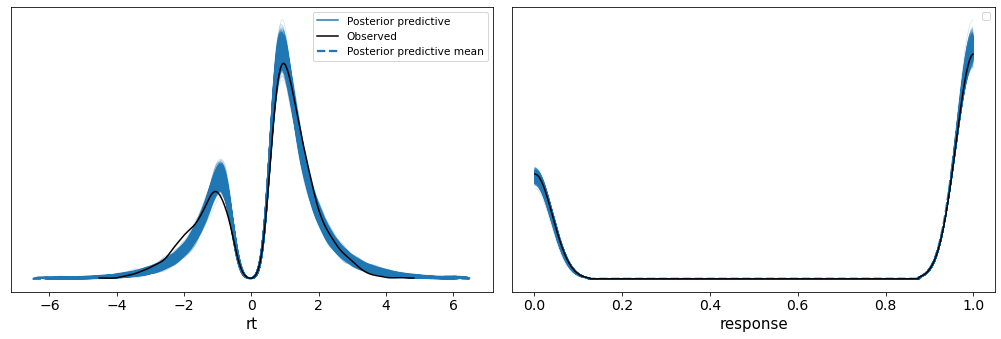

In [22]:
az.plot_ppc(InfData_0_obs)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fec3fe1fd10>,
      dtype=object)

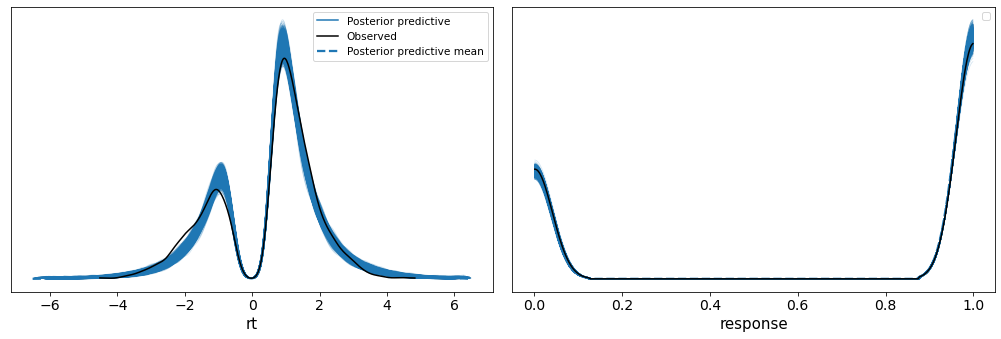

In [23]:
az.plot_ppc(InfData_1_obs)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feb1b03c810>],
      dtype=object)

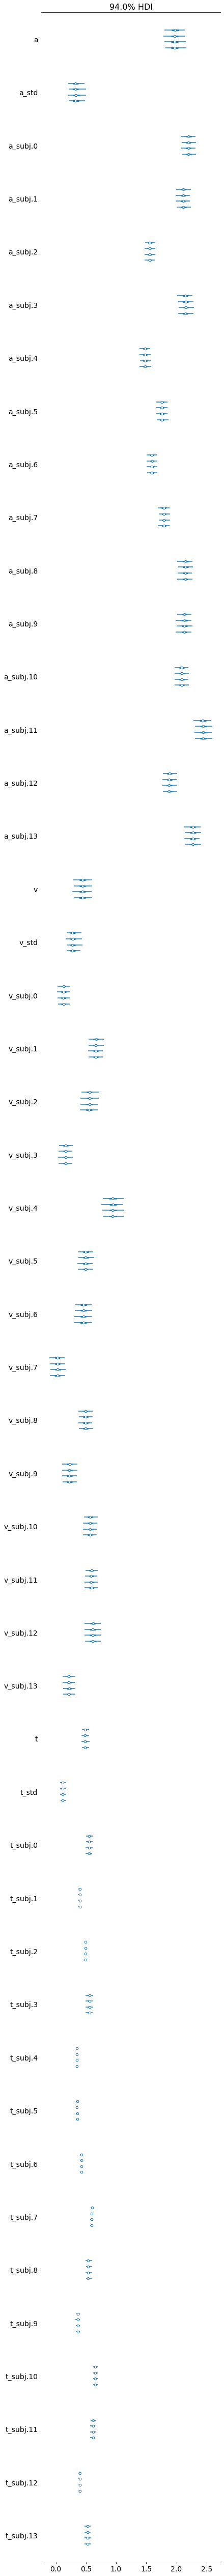

In [24]:
az.plot_forest(InfData_0_obs)

### PS: The `nan` problem

Here we can see that `nan` issue occur even when we try to convert observed data.

In [25]:
obs_data_tmp = data.copy()
obs_data_tmp['trial'] = obs_data_tmp.groupby(['subj_idx', 'stim']).cumcount()
obs_data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
obs_data_tmp = obs_data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)

In [26]:
xdata_observed

<xarray.Dataset>
Dimensions:   (stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (subj_idx, stim, trial) float64 1.21 2.0 1.72 1.72 ... nan nan nan
    response  (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan